In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

In [2]:
# 加载历史数据
data = pd.read_csv('AAPL_old.csv')

# 删除前几行缺失数据
data = data.dropna()

# 计算技术指标
data['SMA'] = data['Close'].rolling(window=5).mean()
data['EMA'] = data['Close'].ewm(span=5).mean()


# 划分特征和目标
X = data[['SMA', 'EMA']]
y = data['Close'].shift(-1)

# 移除最后一行数据，以使X和y具有相同的长度
X = X[:-1]
y = y[:-1]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
# 使用均值填充缺失值
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
# 使用均值填充缺失值
X = imputer.transform(X)

In [4]:


# 初始化随机森林回归模型
model = RandomForestRegressor(n_estimators=100, random_state=42)

# 训练模型
model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

In [5]:
# 在测试集上进行预测
y_pred = model.predict(X_test)

# 计算均方误差
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 26.82499172396984


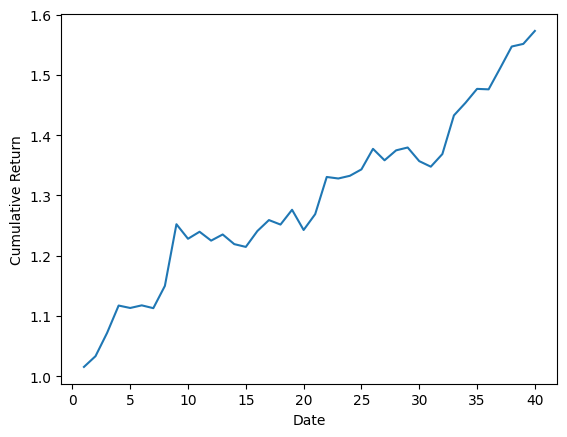

In [6]:
# 预测涨跌幅度
threshold = 0.01
data['Predicted_Change'] = model.predict(X) - data['Close'][:-1]
data['Predicted_Change_Percentage'] = data['Predicted_Change'] / data['Close'][:-1]

# 设定买入卖出信号
data['Signal'] = np.where(data['Predicted_Change_Percentage'] > threshold, 1, -1)

# 计算策略收益
data['Strategy_Return'] = data['Signal'].shift(1) * data['Close'].pct_change()
cumulative_return = (1 + data['Strategy_Return']).cumprod()

# 绘制累积收益曲线
plt.plot(cumulative_return)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

In [7]:
# 计算策略回测收益率
backtest_return = (cumulative_return.iloc[-1] - 1) * 100
print(f"策略回测收益率：{backtest_return:.2f}%")


策略回测收益率：57.28%


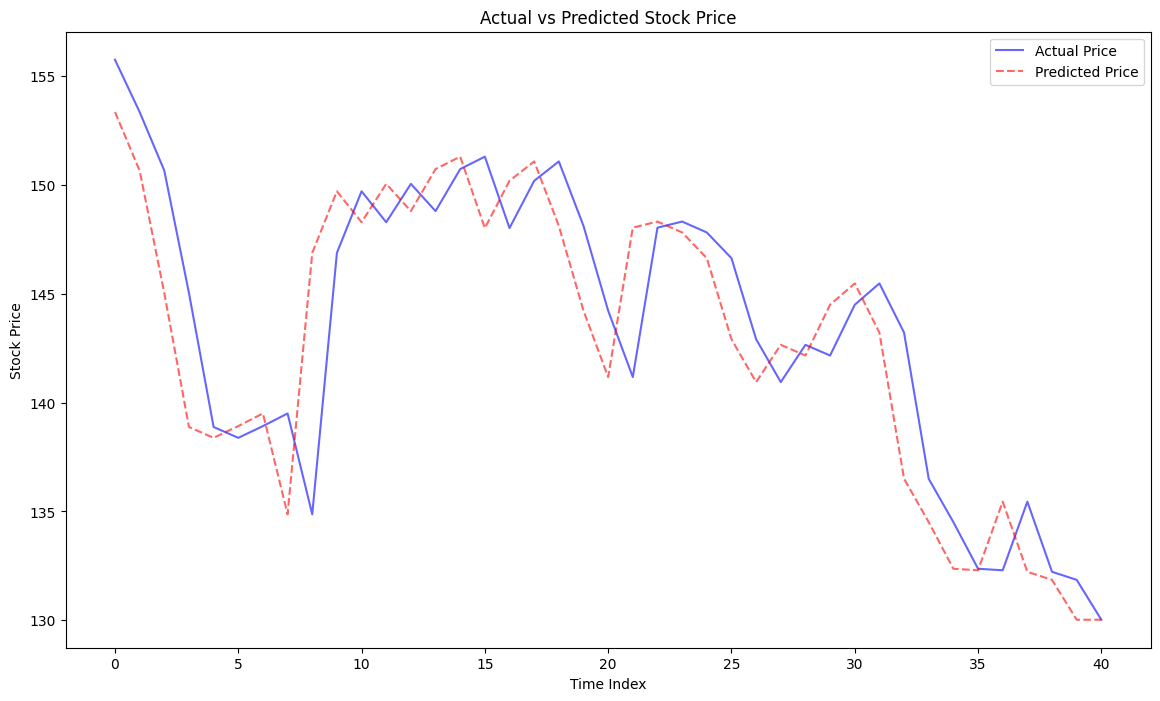

In [8]:
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['Close'], label='Actual Price', c='blue', alpha=0.6)
plt.plot(data.index, data['Close'].shift(-1).fillna(method='ffill'), label='Predicted Price', c='red', linestyle='--', alpha=0.6)
plt.xlabel('Time Index')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Price')
plt.legend()
plt.show()


策略回测收益率：57.28%


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


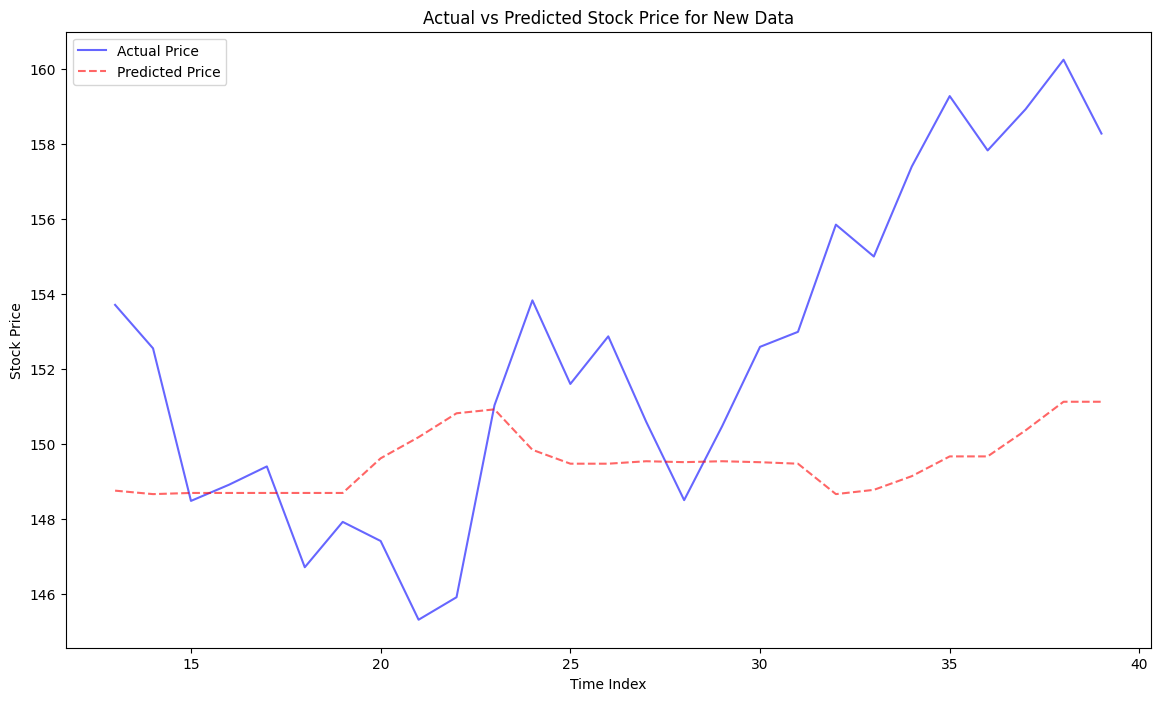

In [9]:
# 加载新的历史数据
new_data = pd.read_csv('AAPL_new.csv')

# 对新数据进行预处理
new_data['SMA'] = new_data['Close'].rolling(window=14).mean()
new_data['EMA'] = new_data['Close'].ewm(span=14, adjust=False).mean()
new_data = new_data.dropna()

# 提取特征
new_X = new_data[['SMA', 'EMA']]

# 使用模型进行预测
new_data['Predicted_Price'] = model.predict(new_X)


# 绘制实际价格和预测价格的对比图
plt.figure(figsize=(14, 8))
plt.plot(new_data.index, new_data['Close'], label='Actual Price', c='blue', alpha=0.6)
plt.plot(new_data.index, new_data['Predicted_Price'], label='Predicted Price', c='red', linestyle='--', alpha=0.6)
plt.xlabel('Time Index')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Price for New Data')
plt.legend()
plt.show()


In [10]:
# 计算预测涨跌幅度
threshold = 0.01
new_data['Predicted_Change'] = new_data['Predicted_Price'] - new_data['Close']
new_data['Predicted_Change_Percentage'] = new_data['Predicted_Change'] / new_data['Close']

# 设定买入卖出信号
new_data['Signal'] = 0
new_data.loc[new_data['Predicted_Change_Percentage'] > threshold, 'Signal'] = 1
new_data.loc[new_data['Predicted_Change_Percentage'] < -threshold, 'Signal'] = -1

# 计算策略收益
new_data['Strategy_Return'] = new_data['Signal'].shift(1) * new_data['Close'].pct_change()
cumulative_return_new = (1 + new_data['Strategy_Return']).cumprod() - 1
total_return_new = cumulative_return_new.iloc[-1]

print(f'策略回测收益率（新数据）：{total_return_new * 100:.2f}%')


策略回测收益率（新数据）：5.06%
